In [1]:
import string
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.models import (
    mobilenet_v2, MobileNet_V2_Weights,
    resnet18, ResNet18_Weights
)

In [2]:
def decompress_npz(npz_file):
    # Load the compressed dataset
    data = np.load(npz_file)
    images = data['images']
    labels = data['labels']

    return images, labels

In [3]:
class LabelMapper:
    # Create a label list containing uppercase letters (A-Z)
    labels = list(string.ascii_uppercase)

    # Create a label-to-index map
    label_to_index_map = {label: idx for idx, label in enumerate(labels)}

    # Create an index-to-label map
    index_to_label_map = {idx: label for idx, label in enumerate(labels)}

    @staticmethod
    def label_to_index(label):
        """
        Convert a label to its corresponding index.
        Args:
            label: The label to convert.
        Returns:
            The index corresponding to the label, or None if the label is not found.
        """
        return LabelMapper.label_to_index_map.get(label, None)

    @staticmethod
    def index_to_label(index):
        """
        Convert an index to its corresponding label.
        Args:
            index: The index to convert.
        Returns:
            The label corresponding to the index, or None if the index is not found.
        """
        return LabelMapper.index_to_label_map.get(index, None)

In [4]:
class ASLDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Initializes the dataset with images and labels.

        Args:
            images (list or array): The dataset of images.
            labels (list): Corresponding labels for each image ('0-9' and 'A-Z').
            transform (callable, optional): Transform to apply to images.
        """
        self.images = images  # List/array of images
        self.labels = labels  # Corresponding labels
        self.transform = transform

        # Convert labels to numerical format
        self.numerical_labels = np.array([LabelMapper.label_to_index(label) for label in labels])

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding label.

        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (image, label) where image is a PIL Image and label is a tensor.
        """
        image = self.images[idx]  # Get image at index
        label = self.numerical_labels[idx]  # Get corresponding label

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor

        return image, label

In [5]:
def plot_performance_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plots the training and validation loss and accuracy over epochs with different colors."""
    plt.figure(figsize=(12, 5))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-')
    plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue', linestyle='-')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


def print_confusion_matrix(y_true, y_pred, report=True):
    # Get sorted unique labels
    labels = sorted(list(set(y_true)))

    # Create confusion matrix
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    # Convert to DataFrame for better readability
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(df_cmx, annot=True, fmt='g', cmap='Blues', square=False)

    # Ensure y-axis is displayed correctly
    ax.set_ylim(len(labels), 0)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Optional: print classification report
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))


In [6]:
def run_epoch(model, dataloader, loss_fn, optimizer, device, train=True):
    """Runs a single epoch for training or validation and returns the average loss and accuracy."""
    if train:
        model.train()  # Set model to training mode
    else:
        model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.set_grad_enabled(train):  # Enable gradients only if training
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Zero gradients only if training
            if train:
                optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            # Backward pass and optimization only if training
            if train:
                loss.backward()
                optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.eq(preds, labels).float().sum()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    avg_accuracy = (correct_preds / total_preds).item()

    return avg_loss, avg_accuracy


def train_model(model, train_loader, val_loader, num_epochs, loss_fn, optimizer, device):
    print("Training Started.")

    # Lists to store loss and accuracy for each epoch
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        # Clear any cached GPU memory
        torch.cuda.empty_cache()

        # Run training and validation phases
        train_loss, train_accuracy = run_epoch(model, train_loader, loss_fn, optimizer, device, train=True)
        val_loss, val_accuracy = run_epoch(model, val_loader, loss_fn, optimizer, device, train=False)

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch metrics
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    print("Training finished.")

    # Plot training and validation loss and accuracy
    plot_performance_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [7]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode

    # Evaluate the model
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation during evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass (get predictions)
            outputs = model(images)

            # Get the predicted class (index of the max logit)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  # Append predictions
            all_labels.extend(labels.cpu().numpy())  # Append true labels

    # Convert indexes to real class labels
    all_preds_labels = [LabelMapper.index_to_label(pred) for pred in all_preds]
    all_labels_labels = [LabelMapper.index_to_label(label) for label in all_labels]

    # Calculate accuracy
    accuracy = accuracy_score(all_labels_labels, all_preds_labels)
    print(f'Accuracy of the model on the test set: {accuracy * 100:.2f}%')

    # Confusion Matrix
    print_confusion_matrix(all_labels_labels, all_preds_labels)

In [13]:
# Load the .npz dataset
images, labels = decompress_npz('../data/compressed_asl_crop_v2.npz')

In [14]:
# Split the images and labels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [8]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set up hyperparameters
num_classes = len(string.ascii_uppercase)
num_epochs = 10
batch_size = 100
learning_rate = 0.001

In [16]:
train_dataset = ASLDataset(X_train, y_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ASLDataset(X_test, y_test, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Corrected input size for fc1
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
# Total classes of uppercase letters (A-Z)
total_classes = len(string.ascii_uppercase)
model = CustomCNN(num_classes=total_classes)

# Move the models to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Custom CNN Summary:")
summary(model, (3, 224, 224))

Custom CNN Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Linear-7                  [-1, 512]      51,380,736
            Linear-8                   [-1, 26]          13,338
Total params: 51,487,322
Trainable params: 51,487,322
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 26.80
Params size (MB): 196.41
Estimated Total Size (MB): 223.78
----------------------------------------------------------------


In [40]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training Started.
Epoch [1/10], Train Loss: 1.0009, Train Accuracy: 72.84%, Val Loss: 0.4213, Val Accuracy: 89.04%
Epoch [2/10], Train Loss: 0.2237, Train Accuracy: 93.73%, Val Loss: 0.3289, Val Accuracy: 91.78%
Epoch [3/10], Train Loss: 0.0896, Train Accuracy: 97.27%, Val Loss: 0.3841, Val Accuracy: 91.57%
Epoch [4/10], Train Loss: 0.0605, Train Accuracy: 98.07%, Val Loss: 0.4104, Val Accuracy: 92.03%
Epoch [5/10], Train Loss: 0.0452, Train Accuracy: 98.55%, Val Loss: 0.4373, Val Accuracy: 91.95%
Epoch [6/10], Train Loss: 0.0355, Train Accuracy: 98.87%, Val Loss: 0.5166, Val Accuracy: 92.00%
Epoch [7/10], Train Loss: 0.0321, Train Accuracy: 98.97%, Val Loss: 0.4746, Val Accuracy: 92.41%
Epoch [8/10], Train Loss: 0.0261, Train Accuracy: 99.19%, Val Loss: 0.5303, Val Accuracy: 92.32%
Epoch [9/10], Train Loss: 0.0226, Train Accuracy: 99.32%, Val Loss: 0.4750, Val Accuracy: 92.34%
Epoch [10/10], Train Loss: 0.0230, Train Accuracy: 99.26%, Val Loss: 0.5402, Val Accuracy: 92.37%
Training fi

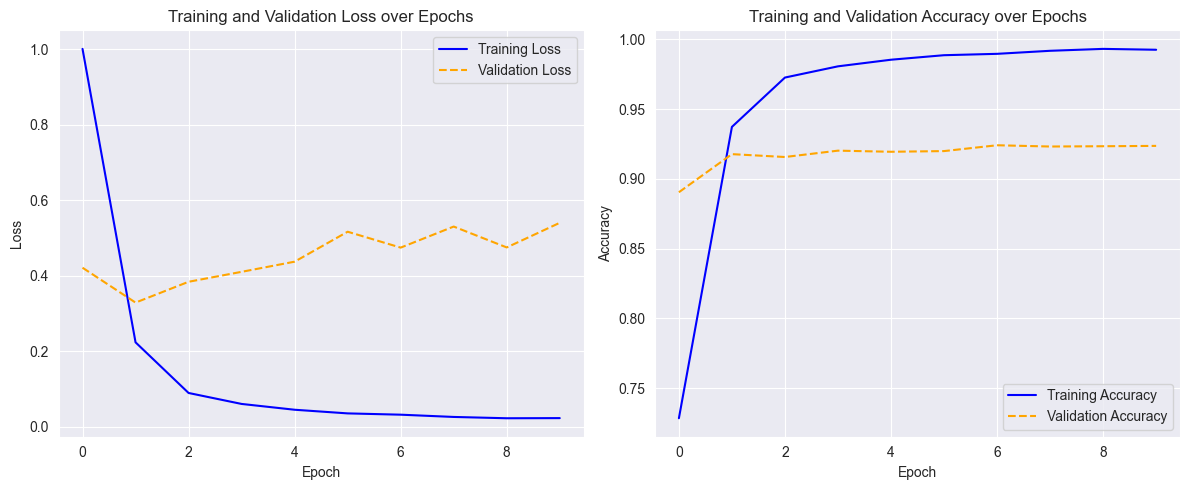

In [33]:
train_model(model, train_loader, val_loader, num_epochs, loss_fn, optimizer, device)

Accuracy of the model on the test set: 92.37%


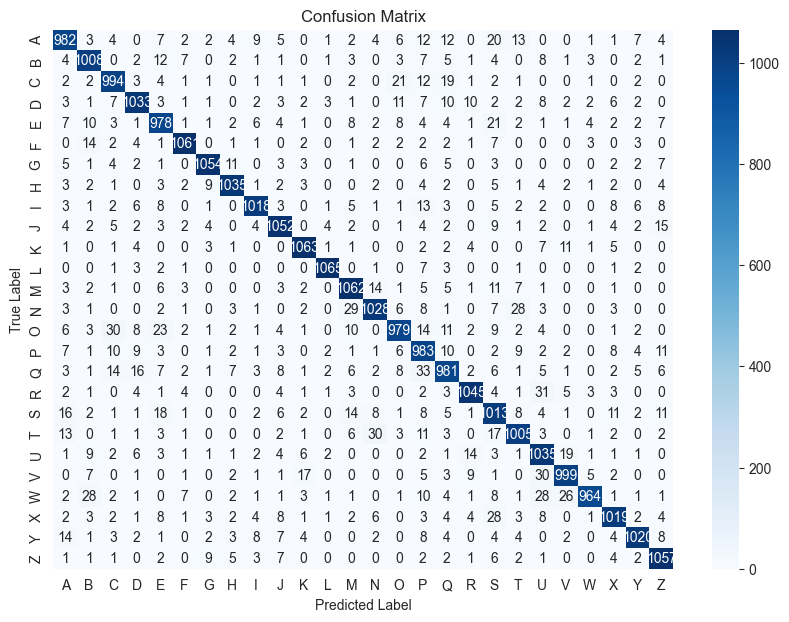

Classification Report
              precision    recall  f1-score   support

           A       0.90      0.89      0.90      1101
           B       0.91      0.94      0.92      1076
           C       0.91      0.93      0.92      1071
           D       0.93      0.92      0.93      1122
           E       0.89      0.90      0.90      1081
           F       0.96      0.96      0.96      1109
           G       0.96      0.95      0.96      1110
           H       0.95      0.95      0.95      1088
           I       0.95      0.93      0.94      1097
           J       0.93      0.94      0.93      1125
           K       0.95      0.96      0.96      1107
           L       0.98      0.98      0.98      1087
           M       0.92      0.94      0.93      1128
           N       0.93      0.91      0.92      1126
           O       0.93      0.88      0.90      1115
           P       0.84      0.91      0.87      1078
           Q       0.89      0.87      0.88      1123
     

In [34]:
evaluate_model(model, val_loader, device)

In [17]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Convolutional layers with added dropout after each pooling layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Adding dropout after pooling layers
        self.dropout_conv = nn.Dropout(0.3)
        
        # Fully connected layers with dropout
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjust input size for fc1
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout_fc = nn.Dropout(0.5)  # Dropout before final layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout_conv(x)  # Dropout after first pooling layer
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout_conv(x)  # Dropout after second pooling layer
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout_conv(x)  # Dropout after third pooling layer
        
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Dropout before final fully connected layer
        x = self.fc2(x)
        return x

In [18]:
# Total classes of uppercase letters (A-Z)
total_classes = len(string.ascii_uppercase)
model = CustomCNN(num_classes=total_classes)

# Move the models to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Custom CNN Summary:")
summary(model, (3, 224, 224))

Custom CNN Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
           Dropout-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
         MaxPool2d-5           [-1, 64, 56, 56]               0
           Dropout-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
         MaxPool2d-8          [-1, 128, 28, 28]               0
           Dropout-9          [-1, 128, 28, 28]               0
           Linear-10                  [-1, 512]      51,380,736
          Dropout-11                  [-1, 512]               0
           Linear-12                   [-1, 26]          13,338
Total params: 51,487,322
Trainable params: 51,487,322
Non-trainable params: 0
-----

Training Started.
Epoch [1/10], Train Loss: 1.9510, Train Accuracy: 44.97%, Val Loss: 0.7950, Val Accuracy: 78.73%
Epoch [2/10], Train Loss: 0.8203, Train Accuracy: 76.21%, Val Loss: 0.4321, Val Accuracy: 87.91%
Epoch [3/10], Train Loss: 0.5256, Train Accuracy: 84.40%, Val Loss: 0.3266, Val Accuracy: 91.29%
Epoch [4/10], Train Loss: 0.3729, Train Accuracy: 88.63%, Val Loss: 0.2547, Val Accuracy: 93.17%
Epoch [5/10], Train Loss: 0.2815, Train Accuracy: 91.25%, Val Loss: 0.2326, Val Accuracy: 93.85%
Epoch [6/10], Train Loss: 0.2283, Train Accuracy: 92.85%, Val Loss: 0.2163, Val Accuracy: 94.40%
Epoch [7/10], Train Loss: 0.1868, Train Accuracy: 94.11%, Val Loss: 0.2131, Val Accuracy: 94.49%
Epoch [8/10], Train Loss: 0.1630, Train Accuracy: 94.85%, Val Loss: 0.2083, Val Accuracy: 94.63%
Epoch [9/10], Train Loss: 0.1369, Train Accuracy: 95.64%, Val Loss: 0.2126, Val Accuracy: 94.83%
Epoch [10/10], Train Loss: 0.1249, Train Accuracy: 96.03%, Val Loss: 0.2005, Val Accuracy: 94.89%
Training fi

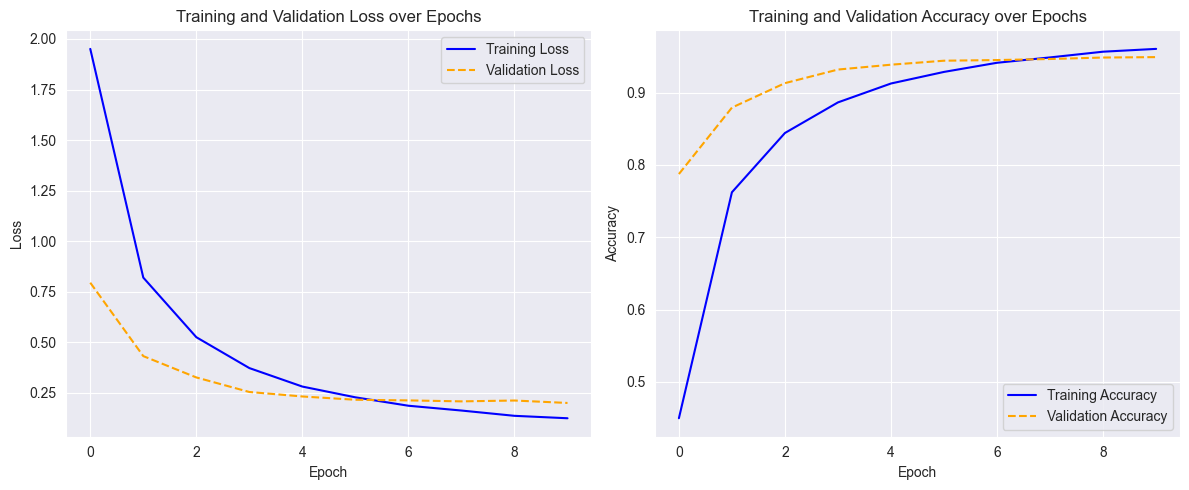

In [46]:
train_model(model, train_loader, val_loader, num_epochs, loss_fn, optimizer, device)

Accuracy of the model on the test set: 94.89%


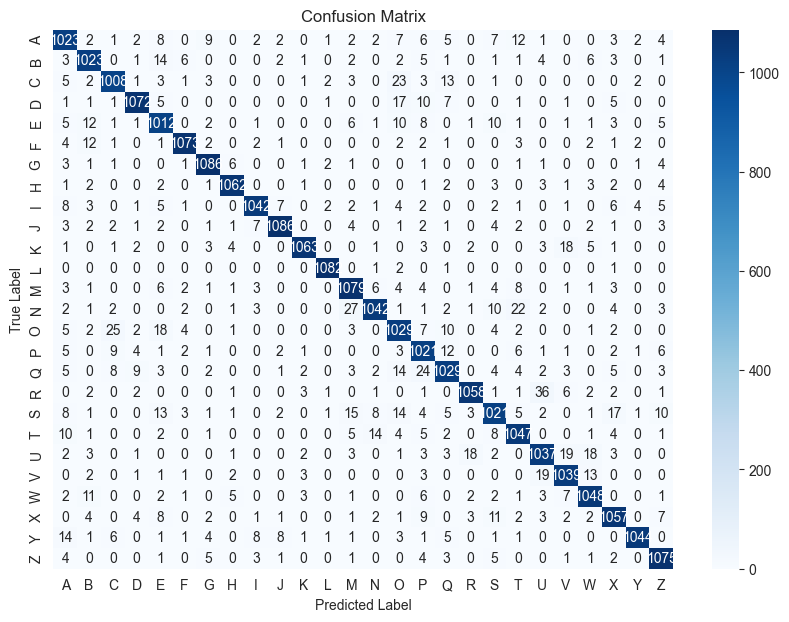

Classification Report
              precision    recall  f1-score   support

           A       0.92      0.93      0.92      1101
           B       0.94      0.95      0.95      1076
           C       0.95      0.94      0.94      1071
           D       0.97      0.96      0.96      1122
           E       0.91      0.94      0.92      1081
           F       0.98      0.97      0.97      1109
           G       0.97      0.98      0.97      1110
           H       0.98      0.98      0.98      1088
           I       0.97      0.95      0.96      1097
           J       0.98      0.97      0.97      1125
           K       0.98      0.96      0.97      1107
           L       0.99      1.00      0.99      1087
           M       0.93      0.96      0.94      1128
           N       0.96      0.93      0.94      1126
           O       0.90      0.92      0.91      1115
           P       0.90      0.95      0.92      1078
           Q       0.93      0.92      0.92      1123
     

In [47]:
evaluate_model(model, val_loader, device)

In [13]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers with added batch normalization and dropout
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Dropout after pooling layers
        self.dropout_conv = nn.Dropout(0.2)
        
        # Fully connected layers with dropout
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)  # Adjusted for additional conv layer
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.dropout_fc = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)
        
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout_conv(x)
        
        x = x.view(-1, 256 * 14 * 14)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout_fc(x)
        
        x = self.fc3(x)
        return x

In [15]:
# Total classes of uppercase letters (A-Z)
total_classes = len(string.ascii_uppercase)
model = CustomCNN(num_classes=total_classes)

# Move the models to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Custom CNN Summary:")
summary(model, (3, 224, 224))

Custom CNN Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
           Dropout-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
         MaxPool2d-7           [-1, 64, 56, 56]               0
           Dropout-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
      BatchNorm2d-10          [-1, 128, 56, 56]             256
        MaxPool2d-11          [-1, 128, 28, 28]               0
          Dropout-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         295,168
      BatchNorm2d-1

Training Started.
Epoch [1/10], Train Loss: 2.3342, Train Accuracy: 29.66%, Val Loss: 1.6024, Val Accuracy: 51.51%
Epoch [2/10], Train Loss: 1.3337, Train Accuracy: 57.56%, Val Loss: 0.7194, Val Accuracy: 80.84%
Epoch [3/10], Train Loss: 0.8118, Train Accuracy: 74.58%, Val Loss: 0.4203, Val Accuracy: 88.55%
Epoch [4/10], Train Loss: 0.5350, Train Accuracy: 83.71%, Val Loss: 0.3289, Val Accuracy: 90.76%
Epoch [5/10], Train Loss: 0.3784, Train Accuracy: 88.60%, Val Loss: 0.2100, Val Accuracy: 94.11%
Epoch [6/10], Train Loss: 0.2861, Train Accuracy: 91.37%, Val Loss: 0.1848, Val Accuracy: 94.84%
Epoch [7/10], Train Loss: 0.2267, Train Accuracy: 93.20%, Val Loss: 0.1443, Val Accuracy: 95.94%
Epoch [8/10], Train Loss: 0.1833, Train Accuracy: 94.47%, Val Loss: 0.1313, Val Accuracy: 96.28%
Epoch [9/10], Train Loss: 0.1530, Train Accuracy: 95.34%, Val Loss: 0.1261, Val Accuracy: 96.40%
Epoch [10/10], Train Loss: 0.1324, Train Accuracy: 95.98%, Val Loss: 0.1193, Val Accuracy: 96.74%
Training fi

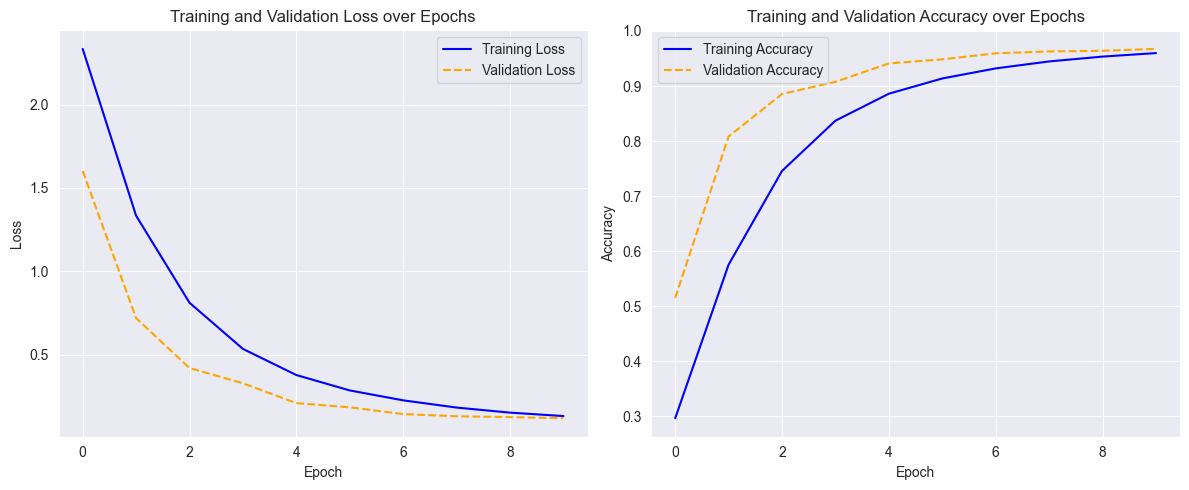

In [16]:
train_model(model, train_loader, val_loader, num_epochs, loss_fn, optimizer, device)

Accuracy of the model on the test set: 96.74%


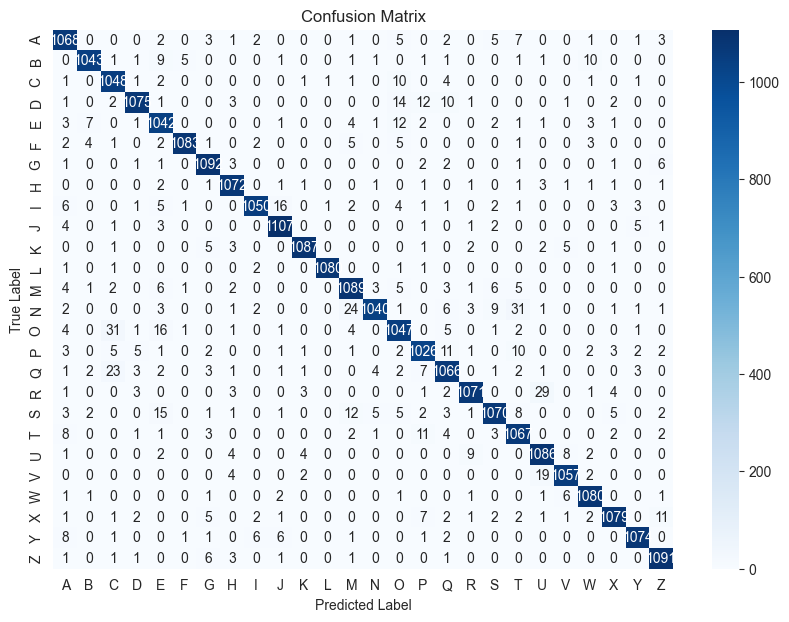

Classification Report
              precision    recall  f1-score   support

           A       0.95      0.97      0.96      1101
           B       0.98      0.97      0.98      1076
           C       0.94      0.98      0.96      1071
           D       0.98      0.96      0.97      1122
           E       0.93      0.96      0.95      1081
           F       0.99      0.98      0.98      1109
           G       0.97      0.98      0.98      1110
           H       0.97      0.99      0.98      1088
           I       0.98      0.96      0.97      1097
           J       0.97      0.98      0.98      1125
           K       0.99      0.98      0.99      1107
           L       1.00      0.99      1.00      1087
           M       0.95      0.97      0.96      1128
           N       0.98      0.92      0.95      1126
           O       0.94      0.94      0.94      1115
           P       0.95      0.95      0.95      1078
           Q       0.95      0.95      0.95      1123
     

In [17]:
evaluate_model(model, val_loader, device)

In [ ]:
images, labels = decompress_npz('../data/compressed_asl_crop_v4.npz')

In [10]:
# Split the images and labels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [11]:
train_dataset = ASLDataset(X_train, y_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ASLDataset(X_test, y_test, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // ratio, 1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // ratio, in_channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        return x * self.sigmoid(avg_out)

In [29]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()
        self.base_model = resnet18(weights=ResNet18_Weights.DEFAULT)

        # Add channel attention only after specific layers
        self.attention1 = ChannelAttention(64)     # After initial conv layer
        self.attention3 = ChannelAttention(128)    # ResNet layer2 output
        self.attention4 = ChannelAttention(256)    # ResNet layer3 output
        self.attention5 = ChannelAttention(512)    # ResNet layer4 output

        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 1280),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        # Initial convolution, batch norm, ReLU, and maxpool
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        # Attention after initial convolution and pooling
        x = self.attention1(x)

        # Pass through ResNet layers with attention after specified layers
        x = self.base_model.layer1(x)

        x = self.base_model.layer2(x)
        x = self.attention3(x)

        x = self.base_model.layer3(x)
        x = self.attention4(x)

        x = self.base_model.layer4(x)
        x = self.attention5(x)

        # Final average pooling and flattening
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)

        # Pass through the modified fully connected layers
        x = self.base_model.fc(x)
        return x

In [30]:
# Total classes of uppercase letters (A-Z)
total_classes = len(string.ascii_uppercase)
model = CustomResNet18(num_classes=total_classes)

# Move the models to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Custom ResNet Summary:")
summary(model, (3, 224, 224))

Custom ResNet Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
 AdaptiveAvgPool2d-5             [-1, 64, 1, 1]               0
            Conv2d-6              [-1, 8, 1, 1]             512
              ReLU-7              [-1, 8, 1, 1]               0
            Conv2d-8             [-1, 64, 1, 1]             512
           Sigmoid-9             [-1, 64, 1, 1]               0
 ChannelAttention-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2

Training Started.
Epoch [1/10], Train Loss: 0.2993, Train Accuracy: 91.45%, Val Loss: 0.1933, Val Accuracy: 94.46%
Epoch [2/10], Train Loss: 0.1359, Train Accuracy: 96.20%, Val Loss: 0.1400, Val Accuracy: 95.85%
Epoch [3/10], Train Loss: 0.0985, Train Accuracy: 97.23%, Val Loss: 0.1531, Val Accuracy: 95.96%
Epoch [4/10], Train Loss: 0.0750, Train Accuracy: 97.86%, Val Loss: 0.2202, Val Accuracy: 95.68%
Epoch [5/10], Train Loss: 0.0619, Train Accuracy: 98.27%, Val Loss: 0.0955, Val Accuracy: 97.44%
Epoch [6/10], Train Loss: 0.0501, Train Accuracy: 98.53%, Val Loss: 0.1023, Val Accuracy: 97.43%
Epoch [7/10], Train Loss: 0.0449, Train Accuracy: 98.72%, Val Loss: 0.0795, Val Accuracy: 98.17%
Epoch [8/10], Train Loss: 0.0339, Train Accuracy: 99.03%, Val Loss: 0.0927, Val Accuracy: 97.86%
Epoch [9/10], Train Loss: 0.0308, Train Accuracy: 99.11%, Val Loss: 0.0801, Val Accuracy: 98.15%
Epoch [10/10], Train Loss: 0.0282, Train Accuracy: 99.21%, Val Loss: 0.0763, Val Accuracy: 98.28%
Training fi

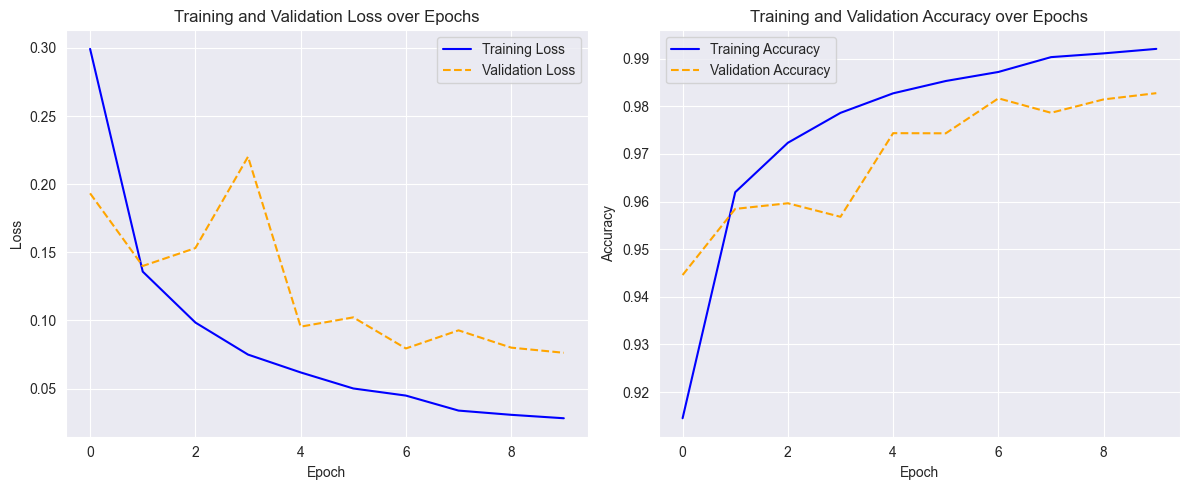

In [31]:
train_model(model, train_loader, val_loader, num_epochs, loss_fn, optimizer, device)

Accuracy of the model on the test set: 98.28%


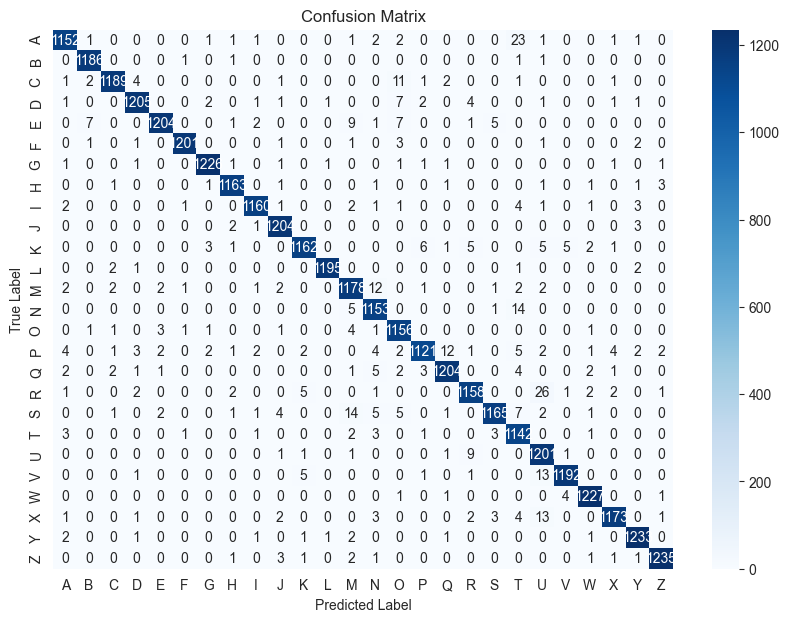

Classification Report
              precision    recall  f1-score   support

           A       0.98      0.97      0.98      1187
           B       0.99      1.00      0.99      1190
           C       0.99      0.98      0.99      1213
           D       0.99      0.98      0.98      1227
           E       0.99      0.97      0.98      1237
           F       1.00      0.99      0.99      1211
           G       0.99      0.99      0.99      1236
           H       0.99      0.99      0.99      1174
           I       0.99      0.99      0.99      1177
           J       0.98      1.00      0.99      1210
           K       0.99      0.98      0.98      1191
           L       1.00      1.00      1.00      1201
           M       0.96      0.98      0.97      1206
           N       0.97      0.98      0.97      1173
           O       0.96      0.99      0.98      1170
           P       0.99      0.96      0.97      1173
           Q       0.98      0.98      0.98      1228
     

In [32]:
evaluate_model(model, val_loader, device)

In [13]:
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(CustomMobileNetV2, self).__init__()
        self.base_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

        # Define attention layers for intermediate and final channel sizes
        self.attention1 = ChannelAttention(32)   # After the first block (32 channels)
        self.attention2 = ChannelAttention(48)   # Adjusted to 48 for smoother transitions
        self.attention3 = ChannelAttention(96)   # After a 96-channel layer
        self.attention4 = ChannelAttention(128)  # Adjusted to 128 for smoother transitions
        self.attention5 = ChannelAttention(256)  # Adjusted to 256 for consistency with ResNet
        self.attention6 = ChannelAttention(512)  # After a 512-channel layer for final layers

        # Update the classifier layer for consistent output dimensions
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.base_model.last_channel, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Initial convolution and attention
        x = self.base_model.features[0](x)
        x = self.attention1(x)

        # Apply attention layers across intermediate stages with smoother transitions
        for i in range(1, len(self.base_model.features)):
            x = self.base_model.features[i](x)

            # Apply corresponding attention based on channel size for smoother transitions
            if x.shape[1] == 48:
                x = self.attention2(x)
            elif x.shape[1] == 96:
                x = self.attention3(x)
            elif x.shape[1] == 128:
                x = self.attention4(x)
            elif x.shape[1] == 256:
                x = self.attention5(x)
            elif x.shape[1] == 512:
                x = self.attention6(x)

        # Pooling and classifier
        x = x.mean([2, 3])  # Global average pooling
        x = self.base_model.classifier(x)
        return x

In [14]:
# Total classes of uppercase letters (A-Z)
total_classes = len(string.ascii_uppercase)
model = CustomMobileNetV2(num_classes=total_classes)

# Move the models to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Custom MobileNetV2 Summary:")
summary(model, (3, 224, 224))

Custom MobileNetV2 Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-4             [-1, 32, 1, 1]               0
            Conv2d-5              [-1, 4, 1, 1]             128
              ReLU-6              [-1, 4, 1, 1]               0
            Conv2d-7             [-1, 32, 1, 1]             128
           Sigmoid-8             [-1, 32, 1, 1]               0
  ChannelAttention-9         [-1, 32, 112, 112]               0
           Conv2d-10         [-1, 32, 112, 112]             288
      BatchNorm2d-11         [-1, 32, 112, 112]              64
            ReLU6-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      Batch

Training Started.
Epoch [1/10], Train Loss: 0.3064, Train Accuracy: 91.22%, Val Loss: 0.3136, Val Accuracy: 91.52%
Epoch [2/10], Train Loss: 0.1335, Train Accuracy: 96.32%, Val Loss: 0.1205, Val Accuracy: 96.74%
Epoch [3/10], Train Loss: 0.1071, Train Accuracy: 96.99%, Val Loss: 0.1107, Val Accuracy: 96.99%
Epoch [4/10], Train Loss: 0.0934, Train Accuracy: 97.39%, Val Loss: 1.8432, Val Accuracy: 73.60%
Epoch [5/10], Train Loss: 0.0790, Train Accuracy: 97.79%, Val Loss: 0.9324, Val Accuracy: 82.84%
Epoch [6/10], Train Loss: 0.0702, Train Accuracy: 98.01%, Val Loss: 0.1851, Val Accuracy: 95.66%
Epoch [7/10], Train Loss: 0.0664, Train Accuracy: 98.13%, Val Loss: 37.6176, Val Accuracy: 5.00%
Epoch [8/10], Train Loss: 0.0547, Train Accuracy: 98.44%, Val Loss: 0.0840, Val Accuracy: 97.69%
Epoch [9/10], Train Loss: 0.0537, Train Accuracy: 98.51%, Val Loss: 0.1045, Val Accuracy: 97.29%
Epoch [10/10], Train Loss: 0.0486, Train Accuracy: 98.61%, Val Loss: 0.6104, Val Accuracy: 87.48%
Training fi

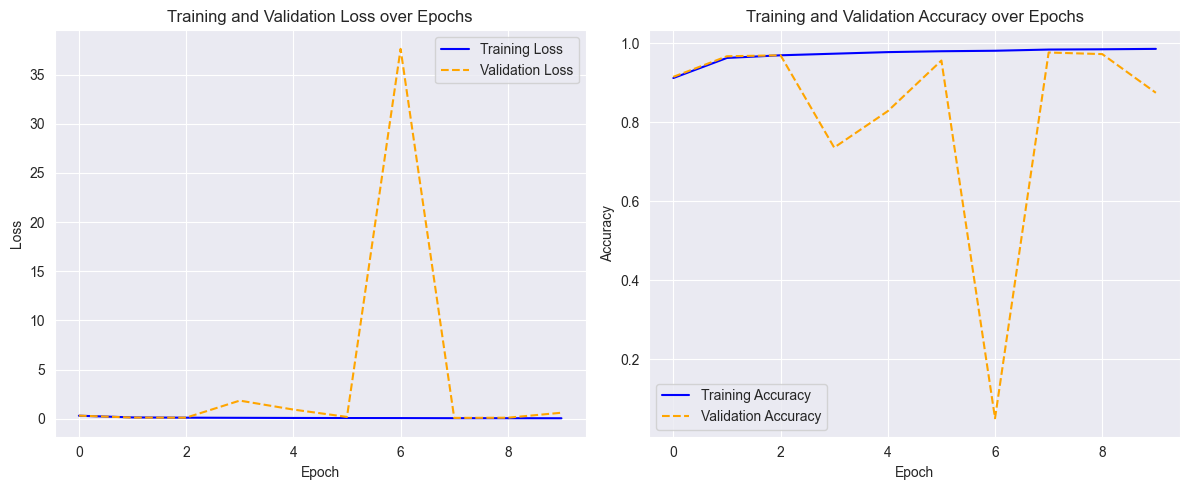

In [37]:
train_model(model, train_loader, val_loader, num_epochs, loss_fn, optimizer, device)

In [ ]:
# Clear any cached GPU memory
torch.cuda.empty_cache()

run_epoch(model, train_loader, loss_fn, optimizer, device, train=True)

Accuracy of the model on the test set: 97.10%


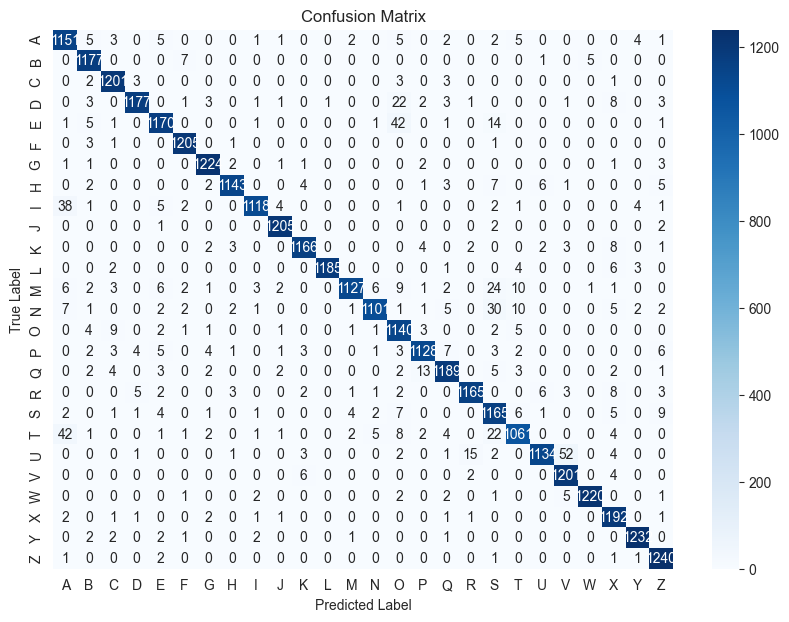

Classification Report
              precision    recall  f1-score   support

           A       0.92      0.97      0.94      1187
           B       0.97      0.99      0.98      1190
           C       0.98      0.99      0.98      1213
           D       0.99      0.96      0.97      1227
           E       0.97      0.95      0.96      1237
           F       0.99      1.00      0.99      1211
           G       0.98      0.99      0.99      1236
           H       0.99      0.97      0.98      1174
           I       0.99      0.95      0.97      1177
           J       0.99      1.00      0.99      1210
           K       0.98      0.98      0.98      1191
           L       1.00      0.99      0.99      1201
           M       0.99      0.93      0.96      1206
           N       0.98      0.94      0.96      1173
           O       0.91      0.97      0.94      1170
           P       0.97      0.96      0.97      1173
           Q       0.97      0.97      0.97      1228
     

In [47]:
evaluate_model(model, val_loader, device)

In [3]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        # Convolutional layers with batch normalization and dropout
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.attention1 = ChannelAttention(32)  # Attention after conv1

        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.attention2 = ChannelAttention(64)  # Attention after conv2

        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.attention3 = ChannelAttention(128)  # Attention after conv3

        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.attention4 = ChannelAttention(256)  # Attention after conv4

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout(0.2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)  # Adjust if image size changes
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.dropout_fc = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.attention1(x)
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.attention2(x)
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.attention3(x)
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.attention4(x)
        x = self.dropout_conv(x)

        # Flatten the output of the convolutional layers dynamically
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc(x)
        x = self.fc3(x)  # Output layer, no activation here unless needed

        return x

In [7]:
# Total classes of uppercase letters (A-Z)
total_classes = len(string.ascii_uppercase)
model = CustomCNN(num_classes=total_classes)

# Move the models to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Custom CNN Summary:")
summary(model, (3, 224, 224))

Custom CNN Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-4             [-1, 32, 1, 1]               0
            Conv2d-5              [-1, 4, 1, 1]             128
              ReLU-6              [-1, 4, 1, 1]               0
            Conv2d-7             [-1, 32, 1, 1]             128
           Sigmoid-8             [-1, 32, 1, 1]               0
  ChannelAttention-9         [-1, 32, 112, 112]               0
          Dropout-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          18,496
      BatchNorm2d-12         [-1, 64, 112, 112]             128
        MaxPool2d-13           [-1, 64, 56, 56]               0
AdaptiveAvgPool2d-1

Training Started.
Epoch [1/10], Train Loss: 1.5101, Train Accuracy: 54.45%, Val Loss: 0.5688, Val Accuracy: 83.74%
Epoch [2/10], Train Loss: 0.5900, Train Accuracy: 82.26%, Val Loss: 0.3786, Val Accuracy: 88.82%
Epoch [3/10], Train Loss: 0.4041, Train Accuracy: 87.93%, Val Loss: 0.3149, Val Accuracy: 91.69%
Epoch [4/10], Train Loss: 0.3063, Train Accuracy: 90.84%, Val Loss: 0.1841, Val Accuracy: 94.83%
Epoch [5/10], Train Loss: 0.2485, Train Accuracy: 92.57%, Val Loss: 0.2078, Val Accuracy: 94.54%
Epoch [6/10], Train Loss: 0.2072, Train Accuracy: 93.73%, Val Loss: 0.1670, Val Accuracy: 95.42%
Epoch [7/10], Train Loss: 0.1765, Train Accuracy: 94.66%, Val Loss: 0.1750, Val Accuracy: 95.21%
Epoch [8/10], Train Loss: 0.1502, Train Accuracy: 95.43%, Val Loss: 0.6139, Val Accuracy: 84.70%
Epoch [9/10], Train Loss: 0.1314, Train Accuracy: 96.00%, Val Loss: 0.1805, Val Accuracy: 95.08%
Epoch [10/10], Train Loss: 0.1136, Train Accuracy: 96.47%, Val Loss: 0.1218, Val Accuracy: 96.85%
Training fi

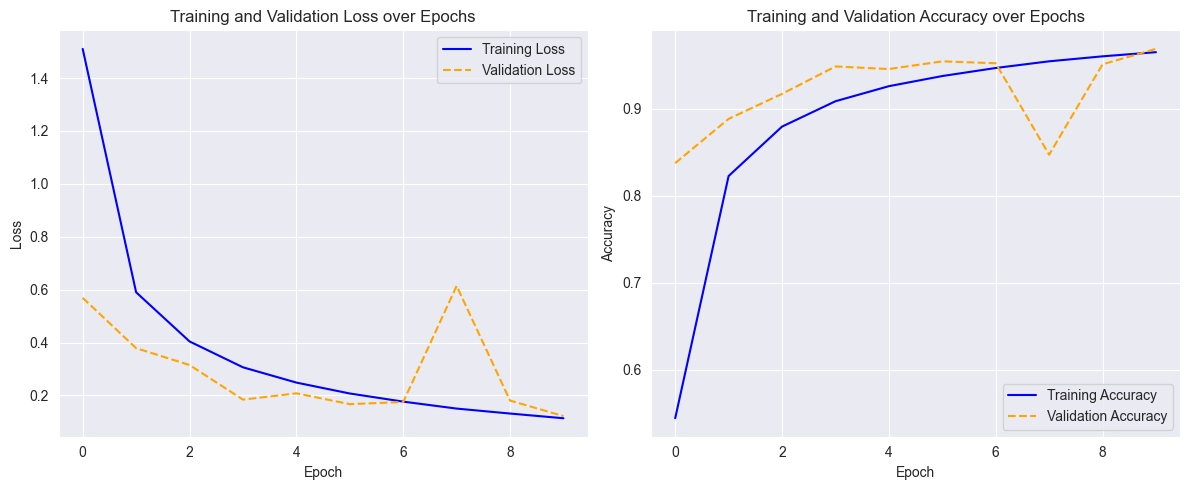

In [55]:
train_model(model, train_loader, val_loader, num_epochs, loss_fn, optimizer, device)

Accuracy of the model on the test set: 96.85%


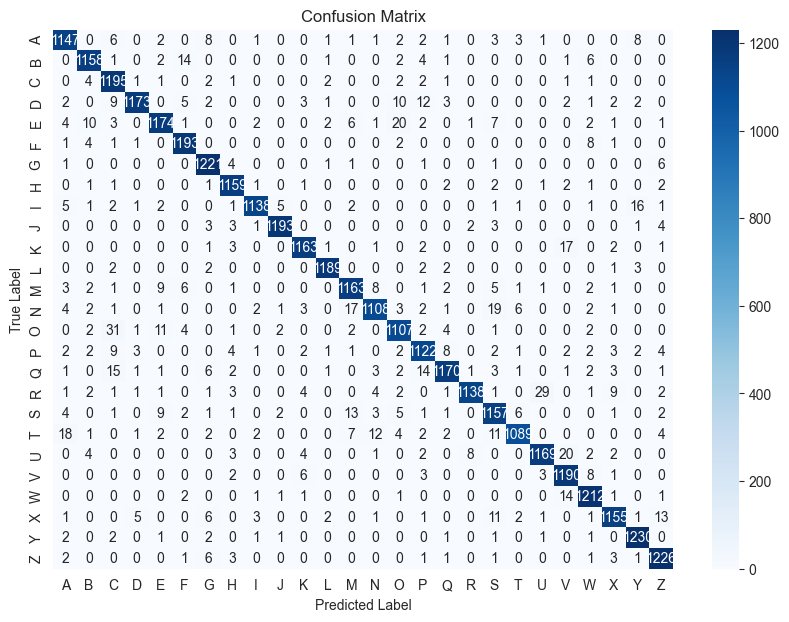

Classification Report
              precision    recall  f1-score   support

           A       0.96      0.97      0.96      1187
           B       0.97      0.97      0.97      1190
           C       0.93      0.99      0.96      1213
           D       0.99      0.96      0.97      1227
           E       0.97      0.95      0.96      1237
           F       0.97      0.99      0.98      1211
           G       0.97      0.99      0.98      1236
           H       0.97      0.99      0.98      1174
           I       0.99      0.97      0.98      1177
           J       0.99      0.99      0.99      1210
           K       0.98      0.98      0.98      1191
           L       0.99      0.99      0.99      1201
           M       0.96      0.96      0.96      1206
           N       0.97      0.94      0.96      1173
           O       0.95      0.95      0.95      1170
           P       0.95      0.96      0.95      1173
           Q       0.97      0.95      0.96      1228
     

In [56]:
evaluate_model(model, val_loader, device)